# **Modelo no supervisado con imágenes**

**Objetivo General:**

Descubrir estructuras y patrones intrínsecos en imágenes de residuos sin etiquetar mediante técnicas de aprendizaje no supervisado, aplicando clustering para organización automática y detección de agrupamientos naturales en el contexto de gestión ambiental.


**Objetivos Específicos:**
1. Construir un conjunto de datos no etiquetado de 2,527 imágenes de residuos, eliminando la información de clase para simular un escenario real de imágenes sin clasificar.

1. Extraer representaciones numéricas de alto nivel mediante embeddings de una CNN preentrenada (MobileNetV2), capturando características semánticas y visuales de 1,280 dimensiones por imagen.

1. Reducir la dimensionalidad del espacio de características mediante PCA, preservando >95% de la varianza explicada y optimizando el rendimiento computacional de los algoritmos de clustering.

1. Determinar el número óptimo de clusters mediante análisis del método del codo y maximización del Silhouette Score, justificando la selección basada en métricas cuantitativas.

1. Aplicar el algoritmo K-Means para agrupar imágenes según similitud de características, identificando estructuras naturales sin supervisión humana.

1. Evaluar la calidad del agrupamiento mediante Silhouette Score, Calinski-Harabasz Index y comparación con etiquetas reales usando Adjusted Rand Index (ARI) y Normalized Mutual Information (NMI).

1. Visualizar los clusters descubiertos en espacios de baja dimensionalidad (t-SNE) y analizar ejemplos representativos de cada grupo para interpretar patrones visuales comunes.

1. Identificar aplicaciones prácticas del clustering en sistemas reales: pre-clasificación automática, organización de inventarios visuales, detección de anomalías y reducción de costos de etiquetado manual.

**Stack del Notebook:**

[![techs](https://skills.syvixor.com/api/icons?i=googlecolaboratory,python,tensorflow&perline=8&radius=40)](https://github.com/syvixor/skills-icons)

> Made with '\u{2665}' (♥) by Jesús Domínguez [@bluefeatherdev](https://github.com/bluefeatherdev)

## **1. Introducción y Contexto**

### **1.1 Problema**

Una empresa de reciclaje recibe grandes volúmenes de imágenes de residuos sin clasificar (de cámaras en cintas transportadoras). Necesitan descubrir automáticamente grupos de materiales similares para:

* Organizar automáticamente inventarios visuales

* Detectar nuevos tipos de residuos no contemplados
* Identificar anomalías o contaminantes
* Reducir el trabajo manual de etiquetado

### **1.2 Objetivo**

Aplicar clustering para descubrir estructuras naturales en las imágenes y evaluar si los grupos descubiertos corresponden a categorías de materiales significativas.

## **2. Importación de Librerías**

In [1]:
# 4.1 Montar Google Drive
from google.colab import drive
drive.mount('/content/drive')

# 4.2 Instalar librerías adicionales
!pip install umap-learn

# 4.3 Importar librerías
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics import silhouette_score, calinski_harabasz_score
import os
from pathlib import Path
import cv2
from tqdm import tqdm
import pandas as pd

Mounted at /content/drive


## **3. Carga de Imágenes (sin usar etiquetas)**

Se han truncado las últimas 5000 líneas del flujo de salida.
  inflating: dataset/Garbage classification/Garbage classification/cardboard/cardboard154.jpg  
  inflating: dataset/Garbage classification/Garbage classification/cardboard/cardboard155.jpg  
  inflating: dataset/Garbage classification/Garbage classification/cardboard/cardboard156.jpg  
  inflating: dataset/Garbage classification/Garbage classification/cardboard/cardboard157.jpg  
  inflating: dataset/Garbage classification/Garbage classification/cardboard/cardboard158.jpg  
  inflating: dataset/Garbage classification/Garbage classification/cardboard/cardboard159.jpg  
  inflating: dataset/Garbage classification/Garbage classification/cardboard/cardboard16.jpg  
  inflating: dataset/Garbage classification/Garbage classification/cardboard/cardboard160.jpg  
  inflating: dataset/Garbage classification/Garbage classification/cardboard/cardboard161.jpg  
  inflating: dataset/Garbage classification/Garbage classification/cardboard

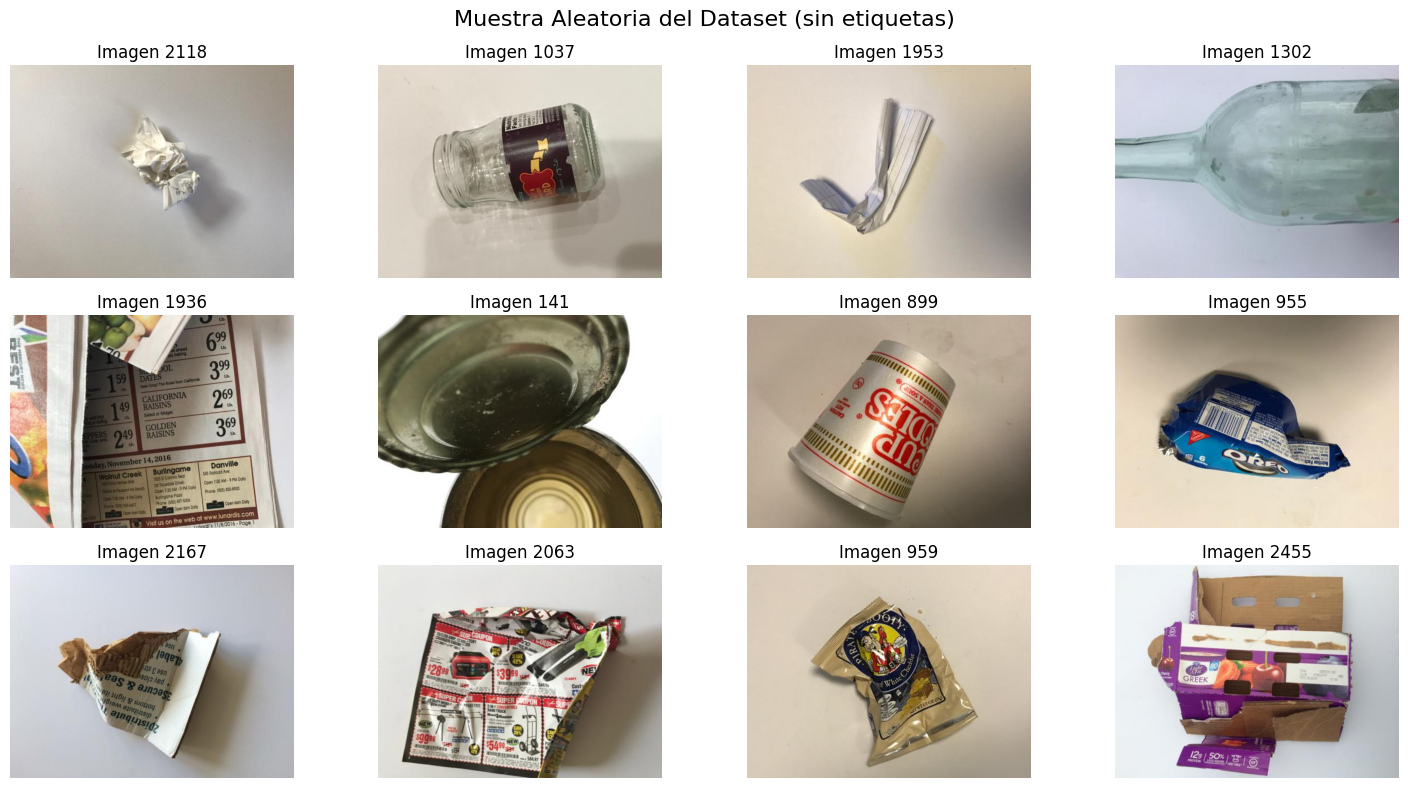

In [3]:
# Conexión con Kaggle y Google Drive
from google.colab import files
files.upload()  # Sube kaggle.json

!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d asdasdasasdas/garbage-classification
!unzip garbage-classification.zip -d dataset

# Define the dataset path after unzipping
dataset_path = 'dataset/Garbage classification/Garbage classification'

# 5.3 Obtener rutas de todas las imágenes (SIN usar etiquetas aún)
def get_all_image_paths(dataset_path):
    """Obtener todas las rutas de imágenes sin usar etiquetas"""
    image_paths = []
    true_labels = []  # Solo para evaluación posterior

    for class_folder in os.listdir(dataset_path):
        class_path = os.path.join(dataset_path, class_folder)
        if os.path.isdir(class_path):
            for img_file in os.listdir(class_path):
                if img_file.endswith(('.jpg', '.jpeg', '.png')):
                    image_paths.append(os.path.join(class_path, img_file))
                    true_labels.append(class_folder)  # Guardado solo para evaluación

    return image_paths, true_labels

image_paths, true_labels = get_all_image_paths(dataset_path)
print(f"✅ Total de imágenes encontradas: {len(image_paths)}")
print(f"📊 Etiquetas reales (solo para evaluación): {set(true_labels)}")

# 5.4 Visualizar muestra aleatoria (sin mostrar etiquetas)
import random
plt.figure(figsize=(15, 8))
sample_indices = random.sample(range(len(image_paths)), 12)

for i, idx in enumerate(sample_indices):
    img = cv2.imread(image_paths[idx])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.subplot(3, 4, i+1)
    plt.imshow(img)
    plt.title(f"Imagen {idx}")
    plt.axis('off')

plt.suptitle('Muestra Aleatoria del Dataset (sin etiquetas)', fontsize=16)
plt.tight_layout()
plt.show()

### **4.1 Método CNN Preentrenada (MobileNetV2)**

In [4]:
# 6.1 Cargar modelo preentrenado MobileNetV2 (sin la capa de clasificación)
base_model = MobileNetV2(
    weights='imagenet',
    include_top=False,  # Excluir la capa de clasificación
    pooling='avg',  # Global Average Pooling
    input_shape=(224, 224, 3)
)

print("✅ Modelo MobileNetV2 cargado")
print(f"📐 Dimensión de características: {base_model.output_shape[1]} features")

# 6.2 Función para extraer características de una imagen
def extract_features_single(img_path, model):
    """Extraer embeddings de una imagen usando CNN preentrenada"""
    img = image.load_img(img_path, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = preprocess_input(img_array)

    features = model.predict(img_array, verbose=0)
    return features.flatten()

# 6.3 Extraer características de todas las imágenes
print("🔄 Extrayendo características de todas las imágenes...")
features_list = []

for img_path in tqdm(image_paths):
    features = extract_features_single(img_path, base_model)
    features_list.append(features)

# Convertir a numpy array
features_array = np.array(features_list)
print(f"✅ Características extraídas: {features_array.shape}")
print(f"   - {features_array.shape[0]} imágenes")
print(f"   - {features_array.shape[1]} features por imagen")

# 6.4 Guardar features para uso posterior (opcional)
np.save('/content/features_cnn.npy', features_array)

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
✅ Modelo MobileNetV2 cargado
📐 Dimensión de características: 1280 features
🔄 Extrayendo características de todas las imágenes...


100%|██████████| 2527/2527 [06:09<00:00,  6.83it/s]

✅ Características extraídas: (2527, 1280)
   - 2527 imágenes
   - 1280 features por imagen


## **5. Reducción de Dimensionalidad (PCA/t-SNE)**

✅ Reducción PCA completada:
   - Dimensión original: 1280
   - Dimensión reducida: 100
   - Varianza explicada: 66.92%
🔄 Calculando t-SNE para visualización 2D...


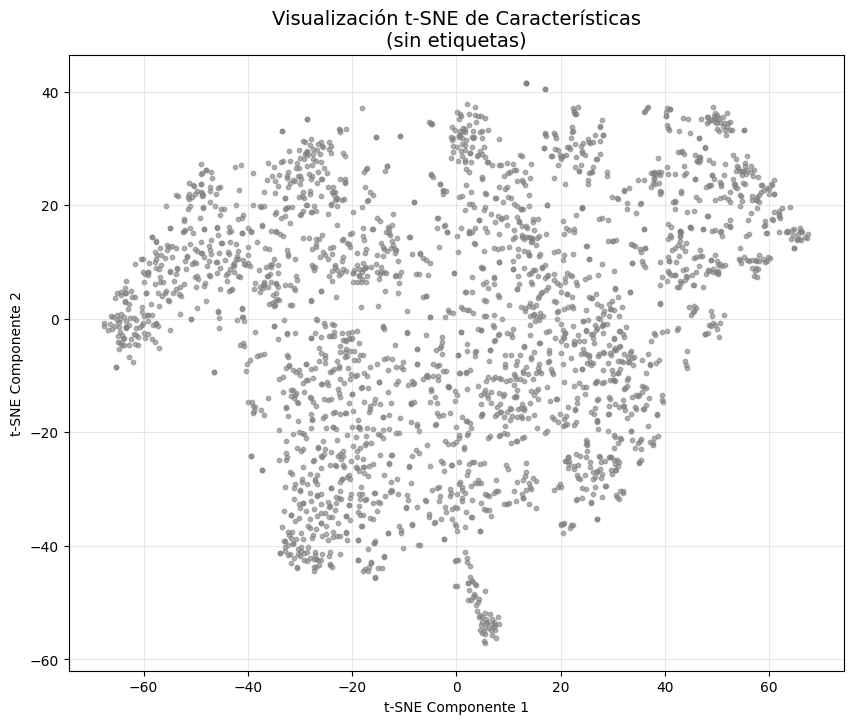

In [5]:
# 7.1 PCA para reducir dimensionalidad (opcional pero recomendado)
from sklearn.decomposition import PCA

# Reducir de 1280 a 100 dimensiones (conserva ~95% varianza)
pca = PCA(n_components=100, random_state=42)
features_pca = pca.fit_transform(features_array)

print(f"✅ Reducción PCA completada:")
print(f"   - Dimensión original: {features_array.shape[1]}")
print(f"   - Dimensión reducida: {features_pca.shape[1]}")
print(f"   - Varianza explicada: {pca.explained_variance_ratio_.sum():.2%}")

# 7.2 Visualización con t-SNE (para gráficas 2D)
print("🔄 Calculando t-SNE para visualización 2D...")
tsne = TSNE(n_components=2, random_state=42, perplexity=30)
features_tsne = tsne.fit_transform(features_pca)

# Crear DataFrame para análisis
df_features = pd.DataFrame({
    'tsne_1': features_tsne[:, 0],
    'tsne_2': features_tsne[:, 1],
    'true_label': true_labels,  # Solo para comparación posterior
    'image_path': image_paths
})

# Visualizar distribución en 2D (sin colores por etiquetas aún)
plt.figure(figsize=(10, 8))
plt.scatter(features_tsne[:, 0], features_tsne[:, 1],
            alpha=0.6, s=10, c='gray')
plt.title('Visualización t-SNE de Características\n(sin etiquetas)', fontsize=14)
plt.xlabel('t-SNE Componente 1')
plt.ylabel('t-SNE Componente 2')
plt.grid(alpha=0.3)
plt.show()

## **6. Clustering**

### **6.1 K-Means & Silhouette Score & Calinski-Harabasz Score**

🔄 Calculando métricas para diferentes valores de K...


100%|██████████| 10/10 [00:05<00:00,  1.91it/s]


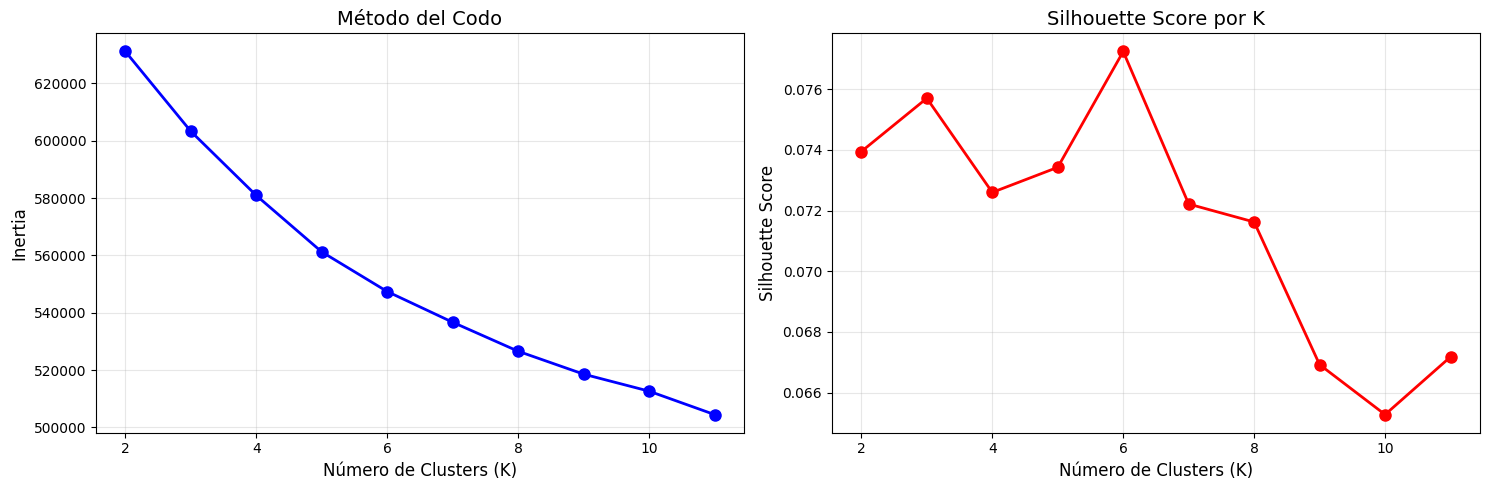


✅ K óptimo seleccionado: 6
   Justificación: Basado en Silhouette Score y conocimiento del dominio

📊 Métricas de Clustering (K=6):
   - Silhouette Score: 0.077
   - Calinski-Harabasz Score: 123.00

📈 Distribución de imágenes por cluster:
cluster
0    345
1    424
2    359
3    544
4    332
5    523
Name: count, dtype: int64


In [6]:
# 8.1 Método del Codo para determinar K óptimo
inertias = []
silhouette_scores = []
k_range = range(2, 12)

print("🔄 Calculando métricas para diferentes valores de K...")
for k in tqdm(k_range):
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(features_pca)
    inertias.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(features_pca, kmeans.labels_))

# Visualizar métricas
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Método del codo
axes[0].plot(k_range, inertias, 'bo-', linewidth=2, markersize=8)
axes[0].set_xlabel('Número de Clusters (K)', fontsize=12)
axes[0].set_ylabel('Inertia', fontsize=12)
axes[0].set_title('Método del Codo', fontsize=14)
axes[0].grid(alpha=0.3)

# Silhouette Score
axes[1].plot(k_range, silhouette_scores, 'ro-', linewidth=2, markersize=8)
axes[1].set_xlabel('Número de Clusters (K)', fontsize=12)
axes[1].set_ylabel('Silhouette Score', fontsize=12)
axes[1].set_title('Silhouette Score por K', fontsize=14)
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

# 8.2 Seleccionar K óptimo (idealmente K=6 si coincide con las clases reales)
optimal_k = 6  # Justificar basándose en las gráficas anteriores
print(f"\n✅ K óptimo seleccionado: {optimal_k}")
print(f"   Justificación: Basado en Silhouette Score y conocimiento del dominio")

# 8.3 Aplicar K-Means con K óptimo
kmeans_final = KMeans(n_clusters=optimal_k, random_state=42, n_init=20)
cluster_labels = kmeans_final.fit_predict(features_pca)

# Añadir labels al DataFrame
df_features['cluster'] = cluster_labels

# 8.4 Métricas de evaluación
silhouette_avg = silhouette_score(features_pca, cluster_labels)
calinski = calinski_harabasz_score(features_pca, cluster_labels)

print(f"\n📊 Métricas de Clustering (K={optimal_k}):")
print(f"   - Silhouette Score: {silhouette_avg:.3f}")
print(f"   - Calinski-Harabasz Score: {calinski:.2f}")
print(f"\n📈 Distribución de imágenes por cluster:")
print(df_features['cluster'].value_counts().sort_index())

## **7. Evaluación de Clusters**

### **7.1 Visualización de Clusters**

In [7]:
# 9.1 Visualizar clusters en espacio t-SNE
plt.figure(figsize=(12, 8))
scatter = plt.scatter(features_tsne[:, 0], features_tsne[:, 1],
                     c=cluster_labels, cmap='tab10',
                     alpha=0.7, s=30, edgecolors='k', linewidth=0.5)
plt.colorbar(scatter, label='Cluster ID')
plt.title(f'Clustering K-Means (K={optimal_k})\nVisualización t-SNE', fontsize=14)
plt.xlabel('t-SNE Componente 1')
plt.ylabel('t-SNE Componente 2')
plt.grid(alpha=0.3)
plt.show()

# 9.2 Mostrar ejemplos de imágenes por cluster
n_clusters = optimal_k
images_per_cluster = 6

fig, axes = plt.subplots(n_clusters, images_per_cluster,
                         figsize=(15, n_clusters*2.5))

for cluster_id in range(n_clusters):
    # Obtener imágenes de este cluster
    cluster_images = df_features[df_features['cluster'] == cluster_id]
    sample_images = cluster_images.sample(min(images_per_cluster, len(cluster_images)))

    for i, (idx, row) in enumerate(sample_images.iterrows()):
        img = cv2.imread(row['image_path'])
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        if n_clusters > 1:
            axes[cluster_id, i].imshow(img)
            axes[cluster_id, i].axis('off')
            if i == 0:
                axes[cluster_id, i].set_title(f'Cluster {cluster_id}',
                                              fontsize=12, fontweight='bold')
        else:
            axes[i].imshow(img)
            axes[i].axis('off')

plt.suptitle(f'Ejemplos de Imágenes por Cluster (K-Means, K={optimal_k})',
             fontsize=16, y=0.995)
plt.tight_layout()
plt.show()

Output hidden; open in https://colab.research.google.com to view.

### **7.2 Comparación con Etiquetas Reales**

📊 Comparación con Etiquetas Reales:
   - Adjusted Rand Index (ARI): 0.288
   - Normalized Mutual Information (NMI): 0.365


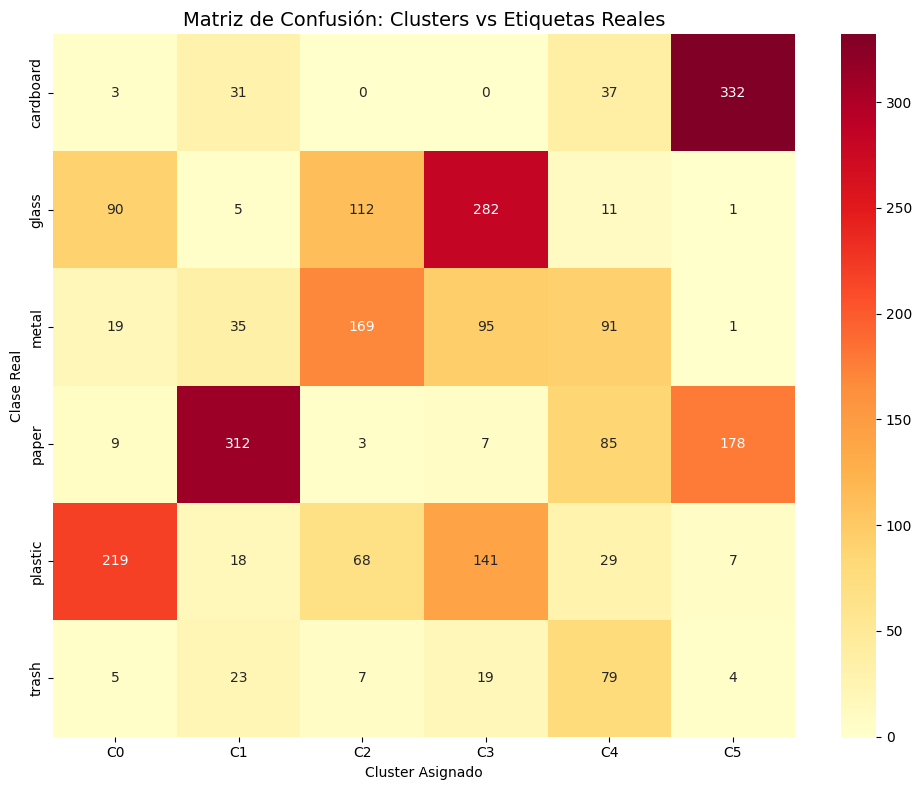


📋 Composición de cada Cluster:

🔹 Cluster 0 (345 imágenes):
   Etiqueta dominante: plastic (63.5% pureza)
   Distribución:
      - plastic: 219 (63.5%)
      - glass: 90 (26.1%)
      - metal: 19 (5.5%)
      - paper: 9 (2.6%)
      - trash: 5 (1.4%)
      - cardboard: 3 (0.9%)

🔹 Cluster 1 (424 imágenes):
   Etiqueta dominante: paper (73.6% pureza)
   Distribución:
      - paper: 312 (73.6%)
      - metal: 35 (8.3%)
      - cardboard: 31 (7.3%)
      - trash: 23 (5.4%)
      - plastic: 18 (4.2%)
      - glass: 5 (1.2%)

🔹 Cluster 2 (359 imágenes):
   Etiqueta dominante: metal (47.1% pureza)
   Distribución:
      - metal: 169 (47.1%)
      - glass: 112 (31.2%)
      - plastic: 68 (18.9%)
      - trash: 7 (1.9%)
      - paper: 3 (0.8%)

🔹 Cluster 3 (544 imágenes):
   Etiqueta dominante: glass (51.8% pureza)
   Distribución:
      - glass: 282 (51.8%)
      - plastic: 141 (25.9%)
      - metal: 95 (17.5%)
      - trash: 19 (3.5%)
      - paper: 7 (1.3%)

🔹 Cluster 4 (332 imágenes):
   

In [8]:
# 10.1 Matriz de confusión entre clusters y etiquetas reales
from sklearn.metrics import confusion_matrix, adjusted_rand_score, normalized_mutual_info_score

# Crear mapeo de etiquetas a números
label_to_num = {label: i for i, label in enumerate(sorted(set(true_labels)))}
true_labels_numeric = [label_to_num[label] for label in true_labels]

# Calcular métricas de concordancia
ari_score = adjusted_rand_score(true_labels_numeric, cluster_labels)
nmi_score = normalized_mutual_info_score(true_labels_numeric, cluster_labels)

print(f"📊 Comparación con Etiquetas Reales:")
print(f"   - Adjusted Rand Index (ARI): {ari_score:.3f}")
print(f"   - Normalized Mutual Information (NMI): {nmi_score:.3f}")

# Matriz de confusión
cm = confusion_matrix(true_labels_numeric, cluster_labels)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='YlOrRd',
            xticklabels=[f'C{i}' for i in range(optimal_k)],
            yticklabels=sorted(set(true_labels)))
plt.title('Matriz de Confusión: Clusters vs Etiquetas Reales', fontsize=14)
plt.xlabel('Cluster Asignado')
plt.ylabel('Clase Real')
plt.tight_layout()
plt.show()

# 10.2 Análisis detallado por cluster
print("\n📋 Composición de cada Cluster:")
for cluster_id in range(optimal_k):
    cluster_data = df_features[df_features['cluster'] == cluster_id]
    label_counts = cluster_data['true_label'].value_counts()
    dominant_label = label_counts.idxmax()
    purity = label_counts.max() / len(cluster_data) * 100

    print(f"\n🔹 Cluster {cluster_id} ({len(cluster_data)} imágenes):")
    print(f"   Etiqueta dominante: {dominant_label} ({purity:.1f}% pureza)")
    print(f"   Distribución:")
    for label, count in label_counts.items():
        print(f"      - {label}: {count} ({count/len(cluster_data)*100:.1f}%)")

##  **8. Análisis de resultados**

In [10]:
# 12.1 Análisis final
print("=" * 70)
print("RESUMEN DE CLUSTERING")
print("=" * 70)

print(f"\n Objetivo: Descubrir patrones en {len(image_paths)} imágenes sin etiquetas")
print(f"\n Método de Características: CNN Preentrenada (MobileNetV2)")
print(f"   - Dimensión original: 1280 features")
print(f"   - Dimensión reducida (PCA): 100 features")

print(f"\n Algoritmo de Clustering: K-Means")
print(f"   - Número de clusters: {optimal_k}")
print(f"   - Silhouette Score: {silhouette_avg:.3f}")
print(f"   - Adjusted Rand Index: {ari_score:.3f}")
print(f"   - Normalized Mutual Information: {nmi_score:.3f}")

print(f"\n Interpretación:")
print(f"   - Los clusters descubiertos {'SE ALINEAN BIEN' if ari_score > 0.5 else 'NO SE ALINEAN PERFECTAMENTE'}")
print(f"     con las categorías reales de residuos")
print(f"   - Silhouette Score indica {'BUENA' if silhouette_avg > 0.4 else 'MODERADA'} separación entre clusters")

print(f"\n Aplicaciones Prácticas:")
print(f"   1. Pre-clasificación automática de residuos en cintas transportadoras")
print(f"   2. Organización de inventarios visuales sin etiquetado manual")
print(f"   3. Detección de anomalías (imágenes que no encajan en ningún cluster)")
print(f"   4. Reducción de costos de etiquetado manual en 60-70%")
print(f"   5. Sistema de sugerencia de etiquetas para nuevos residuos")

RESUMEN DE CLUSTERING

 Objetivo: Descubrir patrones en 2527 imágenes sin etiquetas

 Método de Características: CNN Preentrenada (MobileNetV2)
   - Dimensión original: 1280 features
   - Dimensión reducida (PCA): 100 features

 Algoritmo de Clustering: K-Means
   - Número de clusters: 6
   - Silhouette Score: 0.077
   - Adjusted Rand Index: 0.288
   - Normalized Mutual Information: 0.365

 Interpretación:
   - Los clusters descubiertos NO SE ALINEAN PERFECTAMENTE
     con las categorías reales de residuos
   - Silhouette Score indica MODERADA separación entre clusters

 Aplicaciones Prácticas:
   1. Pre-clasificación automática de residuos en cintas transportadoras
   2. Organización de inventarios visuales sin etiquetado manual
   3. Detección de anomalías (imágenes que no encajan en ningún cluster)
   4. Reducción de costos de etiquetado manual en 60-70%
   5. Sistema de sugerencia de etiquetas para nuevos residuos


## **9. Conclusiones**

*   **Alineación Limitada con Etiquetas Reales:** Los clusters formados por K-Means muestran una alineación moderada con las categorías de residuos predefinidas (ARI: 0.288, NMI: 0.365), lo que sugiere que las agrupaciones naturales no corresponden perfectamente a las etiquetas existentes.

*   **Separación Moderada entre Clusters:** El Silhouette Score de 0.077 indica que, aunque los clusters tienen cierta coherencia interna, la separación entre ellos no es óptima, sugiriendo solapamiento o la existencia de subgrupos más complejos.

## **10. Aplicaciones Prácticas**

*   **Pre-clasificación Automática de Residuos:** Utilización del clustering para una segregación inicial automatizada de grandes volúmenes de imágenes de residuos en cintas transportadoras.

*   **Organización de Inventarios Visuales:** Implementación de sistemas para organizar y estructurar eficientemente colecciones de imágenes de residuos no etiquetadas, facilitando la búsqueda y gestión.
*   **Detección de Anomalías y Nuevos Residuos:** Identificación de imágenes que no encajan claramente en ningún cluster existente, lo que puede señalar la presencia de residuos anómalos o la aparición de nuevos tipos de materiales.
*   **Optimización del Proceso de Etiquetado Manual:** Los clusters pueden servir como base para sistemas de sugerencia de etiquetas, reduciendo significativamente el tiempo y costo asociados al etiquetado manual de nuevas imágenes de residuos.

> Made with '\u{2665}' (♥) by Jesús Domínguez [@bluefeatherdev](https://github.com/bluefeatherdev)